## Load Titanic Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("titanic_data.csv")

In [3]:
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S


## Featuer Seletion, Train Test Split and Data Preprocessing

***
### Train Test Split & First Human Intuition Feature Selection

In [4]:
# Create Numerical Representation of Sex
data['SexNum'] = data['Sex'].apply(lambda x: 0 if x=='female' else 1)

In [5]:
# Select Training Features based on human intuition
features = ['Pclass', 'SexNum', 'SibSp', 'Parch', 'Age'] #'Fare', 
label = 'Survived'

In [6]:
# Train, Test, Cross_Validation Split: 0.6 : 0.2 : 0.2
test_num = int(len(data)*.2)
features_train_test, features_cv, labels_train_test, labels_cv = train_test_split(data[features], data[label],\
                                                                            test_size=test_num, random_state=95)
features_train, features_test, labels_train, labels_test = train_test_split(features_train_test, labels_train_test, \
                                                                           test_size=test_num, random_state=108)

In [7]:
features_train.head(3)

,Pclass,SexNum,SibSp,Parch,Age
52,1,0,1,0,49
466,2,1,0,0,NaN
23,1,1,0,0,28


***
### Data Investigation

In [8]:
features_train.describe()

,Pclass,SexNum,SibSp,Parch,Age
count,535.000000,535.000000,535.000000,535.000000,428.000000
mean,2.295327,0.657944,0.530841,0.386916,30.039533
std,0.838380,0.474842,1.155707,0.791940,14.504245
min,1.000000,0.000000,0.000000,0.000000,0.420000
25%,2.000000,0.000000,0.000000,0.000000,21.000000
50%,3.000000,1.000000,0.000000,0.000000,29.000000
75%,3.000000,1.000000,1.000000,0.000000,38.000000
max,3.000000,1.000000,8.000000,5.000000,80.000000


In [9]:
print len(features_train['Age'].dropna())

428


The count of **Age** is less than the other features and less than the row number of features_train suggest that there is missing values in **Age**.

Investigate the distribution of **Age** attribute to decide strategy for dealing with missing values 

(array([  33.,   27.,   98.,  104.,   72.,   41.,   33.,   15.,    4.,    1.]),
 array([  0.42 ,   8.378,  16.336,  24.294,  32.252,  40.21 ,  48.168,
         56.126,  64.084,  72.042,  80.   ]),
 <a list of 10 Patch objects>)

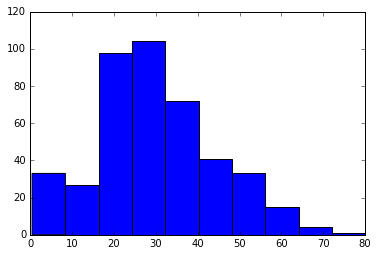

In [9]:
plt.hist(features_train['Age'].dropna().values)

**Using the average of age (~30) to fill in missing values.**
The **Age** histogram shows that despite it is a slightly skewed distribution, the mode of the distribution seems to be **roughly** the same as the mean. Since the value of age will impact decision tree in predicting a sample's survival outcome, extreme value substitute like 0 would be likely to introduce more biase. In addition, previous visulization exploration in **Titanic_Survival_Exploration.ipynb** shows that an age value ranging from [25 - 30] has a relatively low entropy as compared to an age value ranging from [0-10].

In [10]:
# Fill missing values in **Age** variable with its mean found in features_train
features_train['Age'].fillna(30, inplace = True)
features_test['Age'].fillna(30, inplace = True)
features_cv['Age'].fillna(30, inplace = True)

/Users/Zhongyu/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Train Decision Tree Classifier

In [11]:
def DTC(train_X, train_y, test_X, test_y, criterions, min_samples_splits):
    '''examine the best parameter setting'''
    acc = np.zeros((len(criterions), len(min_samples_splits)), dtype=float)
    max_acc = 0
    max_crt = ''
    max_spl = 0
    max_clf = None
    for rid, c in enumerate(criterions):
        for cid, mss in enumerate(min_samples_splits):
            clf = DecisionTreeClassifier(criterion=c, min_samples_split=mss)
            clf.fit(train_X, train_y)
            acc[rid, cid] = clf.score(test_X, test_y)
            if acc[rid, cid] > max_acc:
                max_acc = acc[rid, cid]
                max_crt = criterions[rid]
                max_spl = min_samples_splits[cid]
                max_clf = clf
    return acc, (max_acc, max_crt, max_spl, max_clf)

In [12]:
crts = ['gini', 'entropy']
splits = [10, 20, 30]
acc, best_param = DTC(features_train, labels_train, features_test, labels_test, crts, splits)
print acc
print best_param[:-1]

[[ 0.75842697  0.81460674  0.80337079]
 [ 0.76404494  0.80898876  0.80337079]]
(0.8146067415730337, 'gini', 20)


### Evaluate Performance on Corss Validation Set

In [13]:
best_clf = best_param[-1]
print best_clf.score(features_cv, labels_cv)

0.803370786517


In summary, the best parameters, `[criterion = 'gini', min_samples_split = 20]`, were selected based on the performance on *test set*, which results an accuracy score of *0.8146*. The performance is evaluated on **cross validation set**, achieving an accuracy score of **0.8034**. 

### Would **Fare** increase the performance of the prediction model?

In [14]:
features1 = ['Pclass', 'SexNum', 'SibSp', 'Parch', 'Age', "Fare"] 

In [15]:
features_train_test1, features_cv1, labels_train_test1, labels_cv1 = train_test_split(data[features1], data[label],\
                                                                            test_size=test_num, random_state=95)
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features_train_test1,
                                                                                labels_train_test1, \
                                                                           test_size=test_num, random_state=108)

In [16]:
features_train1.head(3)

,Pclass,SexNum,SibSp,Parch,Age,Fare
52,1,0,1,0,49,76.7292
466,2,1,0,0,NaN,0.0000
23,1,1,0,0,28,35.5000


In [17]:
features_train1.describe()

,Pclass,SexNum,SibSp,Parch,Age,Fare
count,535.000000,535.000000,535.000000,535.000000,428.000000,535.000000
mean,2.295327,0.657944,0.530841,0.386916,30.039533,32.500186
std,0.838380,0.474842,1.155707,0.791940,14.504245,49.927177
min,1.000000,0.000000,0.000000,0.000000,0.420000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,21.000000,7.895800
50%,3.000000,1.000000,0.000000,0.000000,29.000000,15.045800
75%,3.000000,1.000000,1.000000,0.000000,38.000000,31.275000
max,3.000000,1.000000,8.000000,5.000000,80.000000,512.329200


***
**Investigate the distribution of Fare**

(array([ 440.,   63.,   19.,    1.,    7.,    3.,    0.,    0.,    0.,    2.]),
 array([   0.     ,   51.23292,  102.46584,  153.69876,  204.93168,
         256.1646 ,  307.39752,  358.63044,  409.86336,  461.09628,
         512.3292 ]),
 <a list of 10 Patch objects>)

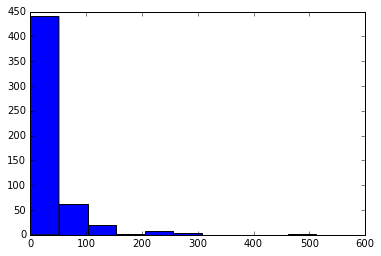

In [18]:
plt.hist(features_train1['Fare'].values)

**Fare** shows a strongly left skewed distribution. Suspecting that **Fare** is somewhat related to **Pclass**. Investigate this using following scatter plot

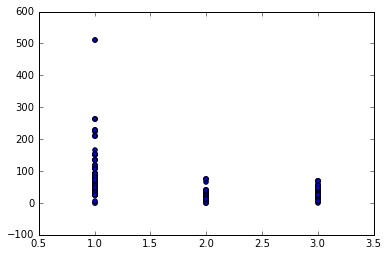

In [19]:
plt.scatter(features_train1['Pclass'].values, features_train1['Fare'].values)

**Fare** is somewhat corrrelated to **Pclass**: the **Fare** for the lower and middle socio-economic class (**Pclass**==3, **Pclass**=2) is in the low value range; the **Fare** for the high socio-economic class (**Pclass**==1) is in the high value range.

However the variance/spread of **Fare** for the high socio-economic class is very large. Therefore, despite its strong correlation with **Pclass**, **Fare** is carrying some extra information about the passengers.

Decision Tree Classifier is not sensitive to variables' absolute value range, and there is no missing values in **Fare**, therefore no extra data processing will be performed upon **Fare** variable.

***
**Fill in missing values in *Age* **

In [20]:
# Fill missing values in **Age** variable with its mean found in features_train
features_train1['Age'].fillna(30, inplace = True)
features_test1['Age'].fillna(30, inplace = True)
features_cv1['Age'].fillna(30, inplace = True)

In [21]:
features_train1.describe()

,Pclass,SexNum,SibSp,Parch,Age,Fare
count,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,2.295327,0.657944,0.530841,0.386916,30.031626,32.500186
std,0.838380,0.474842,1.155707,0.791940,12.969963,49.927177
min,1.000000,0.000000,0.000000,0.000000,0.420000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,23.000000,7.895800
50%,3.000000,1.000000,0.000000,0.000000,30.000000,15.045800
75%,3.000000,1.000000,1.000000,0.000000,35.000000,31.275000
max,3.000000,1.000000,8.000000,5.000000,80.000000,512.329200


***
**Build Decision Tree Classifier with Added New Feature**

In [22]:
crts = ['gini', 'entropy']
splits = [10, 20, 30]
acc1, best_param1 = DTC(features_train1, labels_train1, features_test1, labels_test1, crts, splits)
print acc1
print best_param1[:-1]

[[ 0.75280899  0.81460674  0.80337079]
 [ 0.75280899  0.74719101  0.7752809 ]]
(0.8146067415730337, 'gini', 20)


***
**Evaluate Performance on Cross Validation Set**

In [23]:
best_clf1 = best_param1[-1]
print best_clf1.score(features_cv1, labels_cv1)

0.797752808989


The model included *Fare* feature achieves the same accuracy score as the one without *Fare*. However the performance of model with *Fare* feature included on cross validation set dropped slightly. Overall, since *Fare* featuer does not appear to be crucial for the survial outcome prediction, meanwhile out of the principle of farvoring simple model over complicated ones, *Fare* is **not advised** to be included in building the survival outcome prediction model.

### Explore using GridSearchCV to Determine Parameters

In [24]:
param_dt = {'criterion': ['gini', 'entropy'],
             'splitter' : ['best', 'random'],
             'max_features': [1, 2, 3, 4, 5],
             'min_samples_split' : [2, 5, 10, 20, 30, 40, 50],
             'min_samples_leaf' : [1, 2, 5, 10],
             'random_state' : [96],
             'max_depth' : [10, 15, 20]
            }
dtc = DecisionTreeClassifier()
clf_dtc_gs = GridSearchCV(dtc, param_dt)
clf_dtc_gs.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'splitter': ['best', 'random'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 5, 10, 20, 30, 40, 50], 'random_state': [96], 'criterion': ['gini', 'entropy'], 'max_features': [1, 2, 3, 4, 5], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [25]:
print clf_dtc_gs.score(features_test, labels_test)

0.775280898876


In [27]:
print clf_dtc_gs.score(features_cv, labels_cv)

0.814606741573


In [28]:
print clf_dtc_gs.best_params_

{'splitter': 'random', 'min_samples_leaf': 2, 'min_samples_split': 20, 'random_state': 96, 'criterion': 'gini', 'max_features': 5, 'max_depth': 10}


## Nearest Neighbor Classifier

In [29]:
param_knn = {'n_neighbors' : [1, 3, 5, 10, 15, 20],
             'weights' : ['uniform', 'distance']
            }
knn = KNeighborsClassifier()
clf_knn_gs = GridSearchCV(knn, param_knn)
clf_knn_gs.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [45]:
print clf_knn_gs.score(features_test, labels_test)

0.741573033708


In [30]:
print clf_knn_gs.score(features_cv, labels_cv)

0.747191011236


In [31]:
print clf_knn_gs.best_params_

{'n_neighbors': 3, 'weights': 'distance'}


## AdaBoost Classifier

In [32]:
param_adb = {'n_estimators' : [30, 40, 50, 60, 70],
             'learning_rate' : [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
            }
adb = AdaBoostClassifier()
clf_adb_gs = GridSearchCV(adb, param_adb)
clf_adb_gs.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [30, 40, 50, 60, 70], 'learning_rate': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [33]:
print clf_adb_gs.score(features_test, labels_test)

0.792134831461


In [34]:
print clf_adb_gs.score(features_cv, labels_cv)

0.842696629213


In [35]:
print clf_adb_gs.best_params_

{'n_estimators': 30, 'learning_rate': 0.5}


## Random Forest Classifier

In [36]:
param_rdc = {'n_estimators' : [5, 10, 15, 20],
             'criterion' : ['gini', 'entropy'],
             'min_samples_split' : [2, 5, 10, 20, 30, 40, 50],
             'min_samples_leaf' : [1, 2, 5, 10],
             'max_features' : ['auto', 1, 2, 3, 4, 5]
            }
rdc = RandomForestClassifier()
clf_rdc_gs = GridSearchCV(rdc, param_rdc)
clf_rdc_gs.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20], 'min_samples_split': [2, 5, 10, 20, 30, 40, 50], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 1, 2, 3, 4, 5], 'min_samples_leaf': [1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [37]:
print clf_rdc_gs.score(features_test, labels_test)

0.786516853933


In [38]:
print clf_rdc_gs.score(features_cv, labels_cv)

0.786516853933


In [39]:
print clf_rdc_gs.best_params_

{'max_features': 5, 'min_samples_split': 2, 'n_estimators': 20, 'criterion': 'entropy', 'min_samples_leaf': 2}


## Naive Bayes Calssifier

In [41]:
clf_gnb = GaussianNB()
clf_gnb.fit(features_train, labels_train)
print clf_gnb.score(features_test, labels_test)
print clf_gnb.score(features_cv, labels_cv)

0.797752808989
0.775280898876
